In [105]:
# This is needed for deferring annotation parsing in TVMScript
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.ir.module import IRModule
from tvm.script import relax as R
from tvm.script import tir as T

In [106]:
import IPython


def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.formatters import HtmlFormatter
    from pygments.lexers import Python3Lexer
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

In [107]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def main(
        A: T.Buffer[(128, 128), "float32"],
        B: T.Buffer[(128, 128), "float32"],
        C: T.Buffer[(128, 128), "float32"],
    ):
        T.func_attr({"global_symbol": "main", "tir.noalias": True})
        for i, j, k in T.grid(128, 128, 128):
            with T.block("C"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    C[vi, vj] = 0.0
                C[vi, vj] = C[vi, vj] + A[vi, vk] * B[vk, vj]

一组用于评估的输入和输出

In [108]:
dtype = "float32"
a_np = np.random.rand(128, 128).astype(dtype)
b_np = np.random.rand(128, 128).astype(dtype)
c_mm = a_np @ b_np

构建和运行如下MyModule

In [109]:
a_nd = tvm.nd.array(a_np)
b_nd = tvm.nd.array(b_np)
c_nd = tvm.nd.empty((128, 128), dtype="float32")

lib = tvm.build(MyModule, target="llvm")
f_timer_before = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule: %.3f ms" % (f_timer_before(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule: 1.366 ms


重新组织循环

In [110]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
  block_C = sch.get_block("C", "main")
  i, j, k = sch.get_loops(block=block_C)
  # 将循环分割成两部分
  j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
  # 重新排布
  sch.reorder(i, j_0, k, j_1)
  sch.decompose_reduction(block_C, k)
  return sch

In [111]:
sch = tvm.tir.Schedule(MyModule)
sch = schedule_mm(sch)
IPython.display.HTML(code2html(sch.mod.script()))

In [112]:
lib = tvm.build(sch.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule=>schedule_mm: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule=>schedule_mm: 1.036 ms


可以通过以下方法追踪变换的历史轨迹

In [113]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
l4, l5 = sch.split(loop=l2, factors=[None, 4], preserve_unit_iters=True)
sch.reorder(l1, l4, l3, l5)
b6 = sch.decompose_reduction(block=b0, loop=l3)


In [114]:
def schedule_mm(sch: tvm.tir.Schedule, jfactor=4):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    j_0, j_1 = sch.split(loop=j, factors=[None, jfactor])
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

手动去做需要领域专家的知识，能不能让机器去尝试来做自动化优化

下面来看随机调度变换，`sch.sample_perfect_tile`尝试使用随机数来作为`j_factors`的值，它在输入循环的长度的因子中进行采样，以便采样结果能完美地分割循环。例如，当原始循环长度为 128 时，拆分循环的可能方式包括：[8, 16]、[32, 4]、[2, 64]

In [115]:
def stochastic_schedule_mm(sch: tvm.tir.Schedule):
    block_C = sch.get_block("C", "main")
    i, j, k = sch.get_loops(block=block_C)
    # 随机采样，每次都会有不同的结果
    j_factors = sch.sample_perfect_tile(loop=j, n=2)
    j_0, j_1 = sch.split(loop=j, factors=j_factors)
    sch.reorder(i, j_0, k, j_1)
    sch.decompose_reduction(block_C, k)
    return sch

每次都会随机采样，每次会有不同的采样结果，可以多次运行下方的代码查看效果

In [116]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)

IPython.display.HTML(code2html(sch.mod.script()))

In [117]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[128, 1])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


In [118]:
sch = tvm.tir.Schedule(MyModule)
sch = stochastic_schedule_mm(sch)
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[128, 1])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


深入研究随机变换

随机变换是原始确定性简单泛化，但是包含连个附加元素
+ 来自 sample_perfect_tile 的随机变量和我们在示例中未涵盖的其他采样操作
+ 利用**随机变量**进行的后续变换操作

In [119]:
sch = tvm.tir.Schedule(MyModule)
block_C = sch.get_block("C", "main")
i, j, k = sch.get_loops(block=block_C)
j_factors = sch.sample_perfect_tile(loop=j, n=2)

j_factors中的元素是被采样的随机变量的**符号变量**，最开始不知道其具体值，将其符号化，我们可以将这些变量传递给变换的API从而指定注入因子值之类的选择

In [120]:
type(j_factors[0])

tvm.tir.expr.Var

通过decision可以去尝试各种不同的组合，概率式编程

In [121]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])


虽然这个时候随机数和decision已经确定下来，但是此时对程序还没有变化

In [122]:
IPython.display.HTML(code2html(sch.mod.script()))

In [123]:
IPython.display.HTML(code2html(sch.mod.script()))

In [124]:
j_0, j_1 = sch.split(loop=j, factors=j_factors)
sch.reorder(i, j_0, k, j_1)

In [125]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[32, 4])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)


此时已经对循环进行了变化

In [126]:
IPython.display.HTML(code2html(sch.mod.script()))

可以进一步做一些变换达到最终状态

In [127]:
sch.reorder(i, j_0, k, j_1)
sch.decompose_reduction(block_C, k)

tir.BlockRV(0x661ca40)

In [128]:
IPython.display.HTML(code2html(sch.mod.script()))

随机变换搜索

`stochastic_schedule_mm`创建了一个**可能程序的搜索空间**，具体取决于每个采样步骤中做出的具体决定，那么如何选择最佳的

使用一个搜索算法来做到这一点，下面是一种最简单的搜索算法——随机搜索，它尝试重复运行`stochastic_schedule_mm`，获取转换之后的模块，然后保留历史上最好的模块

In [129]:
def random_search(mod: tvm.IRModule, num_trials=5):
  best_result = None
  best_sch = None

  for i in range(num_trials):
    sch = stochastic_schedule_mm(tvm.tir.Schedule(mod))
    lib = tvm.build(sch.mod, target="llvm")
    f_timer_after = lib.time_evaluator("main", tvm.cpu())
    result = f_timer_after(a_nd, b_nd, c_nd).mean
    
    print("=====Attempt %d, time-cost: %.3f ms====" % (i, result * 1000))
    print(sch.trace)

    if best_result is None or result < best_result:
      best_result = result
      best_sch = sch
    
  return best_sch

sch = random_search(MyModule)

=====Attempt 0, time-cost: 0.639 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[16, 8])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 1, time-cost: 0.502 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)
=====Attempt 2, time-cost: 1.694 ms====
b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[64, 2])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_it

In [130]:
print(sch.trace)

b0 = sch.get_block(name="C", func_name="main")
l1, l2, l3 = sch.get_loops(block=b0)
v4, v5 = sch.sample_perfect_tile(loop=l2, n=2, max_innermost_factor=16, decision=[8, 16])
l6, l7 = sch.split(loop=l2, factors=[v4, v5], preserve_unit_iters=True)
sch.reorder(l1, l6, l3, l7)
b8 = sch.decompose_reduction(block=b0, loop=l3)


在实际中使用了更加智能的搜索算法，如果对其他设备的优化感兴趣，还提供了额外的工具，例如远程设备上的基准测试，TVM的Meta-Schedule API提供了这些附加功能

`meta_schedule`是支持搜索可能变换空间的命名空间，在幕后做了如下事情
+ 跨越多个进程的基准测试
+ 使用**代价模型**来避免每次都进行基准测试，利用机器学习模型进行预测，而不是每个程序都实际去跑一遍
+ 基于历史轨迹进行**遗传搜索**，而不是每次都随机采样

关键思想：**使用随机变换来指定好的程序的搜索空间，使用tune_tir API帮助在搜索空间内搜索并找到最优的调度变换**

In [131]:
from tvm import meta_schedule as ms

sch_tuned = ms.tune_tir(
  mod=MyModule,
  target="llvm --num-cores=1",
  config=ms.TuneConfig(
    max_trials_global=64,
    num_trials_per_iter=64,
  ),
  # 指定搜索空间，在实际情况中无需指定搜索空间，工具本身后分析程序中的一些规律，使用一些分析和规则
  space=ms.space_generator.ScheduleFn(stochastic_schedule_mm),
  work_dir="./tune_tmp",
  task_name="main"
)

2022-10-27 22:10:53.293 INFO Logging directory: ./tune_tmp/logs
2022-10-27 22:10:53.297 INFO Logging directory: ./tune_tmp/logs
2022-10-27 22:10:53.298 INFO Working directory: ./tune_tmp
2022-10-27 22:10:53.298 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-10-27 22:10:53.404 INFO LocalBuilder: max_workers = 6
2022-10-27 22:10:53.801 INFO LocalRunner: max_workers = 1
2022-10-27 22:10:54.208 INFO Initializing Task #0: "main"
2022-10-27 22:10:54.220 INFO 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |            
------------------------------------------------------------------------------------------------------------
Total trials: 

/home/patrick/miniconda3/envs/mlc/lib/python3.9/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


查看优化后的调度

In [132]:
print(sch_tuned.trace)

b0 = sch.get_block(name="C", func_name="main")
b1 = sch.get_block(name="root", func_name="main")
sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
l2, l3, l4 = sch.get_loops(block=b0)
v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[64, 2, 1, 1])
l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[1, 1, 16, 8])
l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[8, 16])
l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
b25 = sch.cache_write(block=b0, write_buffer_index=0, storage_scope="global")
sch.reverse_compute_at(block=b25, loop=l18, preserve_unit_loops=True)

In [133]:
IPython.display.HTML(code2html(sch_tuned.mod.script()))

In [134]:
lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.083 ms


In [135]:
lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.042 ms


利用默认的自动调度

Meta-Schedule带有内置通用随机变换集合，能够适用于广泛的TensorIR计算。这种方法也称为自动调度 (auto-scheduling)，因为搜索空间是由系统生成的，我们可以通过删除行`space=ms.space_generator.ScheduleFn(stochastic_schedule_mm)`来运行它，这个搜索空间（变化空间）比之前指定的要大得多

在底层，Meta-Schedule分析每个TensorIR bloc 的数据访问和循环模式，并提出对程序的随机变换方式。，但要注意它们是随机转换加上代码分析而已

In [136]:
sch_tuned = ms.tune_tir(
    mod=MyModule,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir="./tune_tmp",
    task_name="main",
)

2022-10-27 22:11:17.598 INFO Logging directory: ./tune_tmp/logs
2022-10-27 22:11:17.600 INFO Logging directory: ./tune_tmp/logs
2022-10-27 22:11:17.600 INFO Working directory: ./tune_tmp
2022-10-27 22:11:17.600 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-10-27 22:11:17.735 INFO LocalBuilder: max_workers = 6
2022-10-27 22:11:18.131 INFO LocalRunner: max_workers = 1
2022-10-27 22:11:18.514 INFO Initializing Task #0: "main"
2022-10-27 22:11:18.528 INFO 
 ID | Name |    FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
------------------------------------------------------------------------------------------------------------
  0 | main | 4194304 |      1 |            N/A |          N/A |                   N/A |      0 |            
------------------------------------------------------------------------------------------------------------
Total trials: 

/home/patrick/miniconda3/envs/mlc/lib/python3.9/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


In [137]:
lib = tvm.build(sch_tuned.mod, target="llvm")
f_timer_after = lib.time_evaluator("main", tvm.cpu())
print("Time cost of MyModule after tuning: %.3f ms" % (f_timer_after(a_nd, b_nd, c_nd).mean * 1000))

Time cost of MyModule after tuning: 0.042 ms


结果比我们的原始代码快得多，在高层次的理解中，历史轨迹包含
+ 更多级的循环转换，更多层的循环可能有更好的局部性，对cache更加友好
+ 中间计算的矢量化
+ 并行化和循环展开

In [138]:
sch_tuned.trace

b0 = sch.get_block(name="C", func_name="main")
b1 = sch.get_block(name="root", func_name="main")
sch.annotate(block_or_loop=b0, ann_key="meta_schedule.tiling_structure", ann_val="SSRSRS")
l2, l3, l4 = sch.get_loops(block=b0)
v5, v6, v7, v8 = sch.sample_perfect_tile(loop=l2, n=4, max_innermost_factor=64, decision=[64, 2, 1, 1])
l9, l10, l11, l12 = sch.split(loop=l2, factors=[v5, v6, v7, v8], preserve_unit_iters=True)
v13, v14, v15, v16 = sch.sample_perfect_tile(loop=l3, n=4, max_innermost_factor=64, decision=[1, 1, 16, 8])
l17, l18, l19, l20 = sch.split(loop=l3, factors=[v13, v14, v15, v16], preserve_unit_iters=True)
v21, v22 = sch.sample_perfect_tile(loop=l4, n=2, max_innermost_factor=64, decision=[8, 16])
l23, l24 = sch.split(loop=l4, factors=[v21, v22], preserve_unit_iters=True)
sch.reorder(l9, l17, l10, l18, l23, l11, l19, l24, l12, l20)
b25 = sch.cache_write(block=b0, write_buffer_index=0, storage_scope="global")
sch.reverse_compute_at(block=b25, loop=l18, preserve_unit_loops=True)

In [139]:
IPython.display.HTML(code2html(sch_tuned.mod.script()))

+ 随机调度允许我们表示“可能的变换是什么”，提供一个**搜索空间**
+ Meta-Schedule的tune_tir API帮助我们在搜索空间内找到一个好的解决方案
+ Meta-Schedule带有一组默认的内置随机变换，涵盖了广泛的搜索空间

自动搜索是一个模块化的步骤，我们只需要**用调优结果提供的新的元张量函数实现替换原始的元张量函数实现**

In [140]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

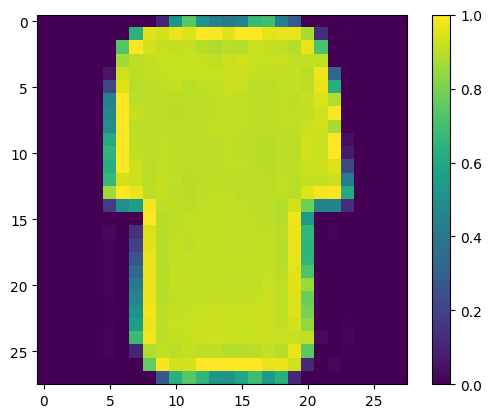

Class: Shirt


In [141]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [142]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [143]:
@tvm.script.ir_module
class MyModuleMixture:
    @T.prim_func
    # 对linear0进行优化，体会优化后的函数对端到端实现中性能的影响
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @R.function
    def main(x: Tensor((1, 784), "float32"),
             w0: Tensor((128, 784), "float32"),
             b0: Tensor((128,), "float32"),
             w1: Tensor((10, 128), "float32"),
             b1: Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), (1, 128), dtype="float32")
            lv1 = R.call_tir("env.relu", (lv0,), (1, 128), dtype="float32")
            out = R.call_tir("env.linear", (lv1, w1, b1), (1, 10), dtype="float32")
            R.output(out)
        return out

In [144]:
@tvm.register_func("env.linear", override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def lnumpy_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

In [145]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)

In [146]:
ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: T-shirt/top


In [147]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=100)

print("MyModuleWithParams time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.0917151 ms


将linear0取出到另一个模块的main函数中并将其传递给tune_tir，每个IRModule都需要一个main函数，这是工具本身的限制，先将linear拿出来放到一个main中去做优化

In [148]:
mod_linear = tvm.IRModule.from_expr(MyModuleMixture["linear0"].with_attr("global_symbol", "main"))
IPython.display.HTML(code2html(mod_linear.script()))

In [149]:
sch_tuned_linear = ms.tune_tir(
    mod=mod_linear,
    target="llvm --num-cores=1",
    config=ms.TuneConfig(
      max_trials_global=64,
      num_trials_per_iter=64,
    ),
    work_dir="./tune_tmp",
    task_name="main",
)

2022-10-27 22:11:50.366 INFO Logging directory: ./tune_tmp/logs
2022-10-27 22:11:50.367 INFO Logging directory: ./tune_tmp/logs
2022-10-27 22:11:50.368 INFO Working directory: ./tune_tmp
2022-10-27 22:11:50.368 INFO Creating JSONDatabase. Workload at: ./tune_tmp/database_workload.json. Tuning records at: ./tune_tmp/database_tuning_record.json
2022-10-27 22:11:50.508 INFO LocalBuilder: max_workers = 6
2022-10-27 22:11:50.900 INFO LocalRunner: max_workers = 1
2022-10-27 22:11:51.287 INFO Initializing Task #0: "main"
2022-10-27 22:11:51.305 INFO 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Terminated 
-----------------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |            N/A |          N/A |                   N/A |      0 |            
-----------------------------------------------------------------------------------------------------------
Total trials: 0
To

/home/patrick/miniconda3/envs/mlc/lib/python3.9/site-packages/xgboost/training.py:19: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


我们需要在调优后用新函数替换原来的linear0。我们可以通过首先获得一个global_var（一个指向IRModule中函数的pointer引用），然后调用update_func来用新的函数替换原本的函数

In [150]:
MyModuleWithParams2 = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
new_func = sch_tuned_linear.mod["main"].with_attr("global_symbol", "linear0")
gv = MyModuleWithParams2.get_global_var("linear0")
# 更新原来的函数，使用优化后的替代
MyModuleWithParams2.update_func(gv, new_func)
IPython.display.HTML(code2html(MyModuleWithParams2.script()))

上面代码中的linear0已经被替换了

In [151]:
ex = relax.vm.build(MyModuleWithParams2, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])

MyModuleWithParams2 Prediction: T-shirt/top


In [152]:
ftimer = vm.module.time_evaluator("main", tvm.cpu(), number=50)

print("MyModuleWithParams2 time-cost: %g ms" % (ftimer(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.149755 ms
